# XY - Regression - Group 11

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
class LaneDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        # Standard JetBot transforms + Color Augmentation
        self.transform = transform if transform else transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            # Normalize using ImageNet stats (standard for ResNet)
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0] # Filename
        img_path = os.path.join(self.root_dir, img_id)
        
        # Check if file exists in folder
        if not os.path.exists(img_path):
            return self.__getitem__((index + 1) % len(self.annotations))
        
        image = Image.open(img_path).convert("RGB")
        
        # Get the X, Y coordinates
        label = torch.tensor(
            self.annotations.iloc[index, 1:3].values.astype('float32')
        ) # Columns 1 and 2 are x_norm, y_norm

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
# Hyperparameters
batch_size = 16

#data_dir = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\BIP_images_roboter_cam_allinone\all"
#csv_file = "labels.csv"

data_dir = "./dataset/all_original"
csv_file = "./dataset/labels_original.csv"

# Ratio: 80% train, 10% test, 10% validation
train_dir = "./dataset/train_original" # Training Dataset
test_dir = "./dataset/test_original"   # Testing Dataset
val_dir = "./dataset/val_original"     # Validation Dataset

In [4]:
full_dataset = LaneDataset(csv_file=csv_file, root_dir=data_dir)

train_dataset = LaneDataset(csv_file = csv_file, root_dir = train_dir)
test_dataset = LaneDataset(csv_file = csv_file, root_dir = test_dir)
val_dataset = LaneDataset(csv_file = csv_file, root_dir = val_dir)

In [5]:
# Split into Train (80%) and Validation (20%)
#train_size = int(0.8 * len(full_dataset))
#test_size = len(full_dataset) - train_size
#train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

#train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
#test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)  # check if shuffle needs to be done here too

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=True) # drop last avoids error
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

In [6]:
# Setup Model
# Load ResNet18 pre-trained on ImageNet
model = models.mobilenet_v3_small(weights = True) # mobilenet_v3_large also exists

# Modify the final layer: Input features -> 2 Output features (X, Y)
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, 2)
print(model.classifier)

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=2, bias=True)
)


C:\Users\agah2\miniconda3\envs\bip\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda


In [8]:
summary(model, input_size = (3, 224, 224))    # if using torchsummary # change back to 128 128

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

In [9]:
# Hyperparameters
lr = 1e-4
epochs = 60

# Training Setup
optimizer = optim.AdamW(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

print(f"Training on {device} with {len(train_dataset)} images...")

Training on cuda with 3797 images...


In [10]:
train_losses = []
val_losses = []
train_maes = [] # mean absolut error (between prediction and label)
val_maes = []

# calculate metric for regression (accuracy)
def calculate_mae(outputs, labels):
    return torch.abs(outputs - labels).mean().item() # how far is the prediction off to the actual labels (groudn truth)

In [11]:
best_val_loss = float('inf')

# training loop
for epoch in range(epochs):
    # training
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    
    # loading bar for showing progress
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} / {epochs} [Train]", unit="batch", leave=False)
    
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        current_mae = calculate_mae(outputs, labels)
        running_mae += current_mae
        
        # Update the progress bar with the current batch loss
        train_bar.set_postfix(loss=f"{loss.item():.4f}", mae=f"{current_mae:.4f}")
    
    avg_train_loss = running_loss / len(train_loader)
    avg_train_mae = running_mae / len(train_loader)
    train_losses.append(avg_train_loss)
    train_maes.append(avg_train_mae)
    
    # validation
    model.eval()
    running_val_loss = 0.0
    running_val_mae = 0.0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", unit="batch", leave=False)
    
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            v_loss = loss_fn(outputs, labels).item()
            v_mae = calculate_mae(outputs, labels)
            
            running_val_loss += v_loss
            running_val_mae += v_mae
            
            val_bar.set_postfix(val_loss=f"{v_loss:.4f}", val_mae=f"{v_mae:.4f}")
            
    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_mae = running_val_mae / len(val_loader)
    val_losses.append(avg_val_loss)
    val_maes.append(avg_val_mae)
    
    # print losses etc
    print(f"Epoch {epoch+1} / {epochs}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val MAE: {avg_val_mae:.4f}")
    
    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), './models/best_steering_model_xy_MobileNetV3.pth')
        print("Saved Best Model (Validation Loss Improved)\n")

print("\n Training Done")

Epoch 1 / 60: Train Loss: 0.0280 | Val Loss: 0.0075 | Val MAE: 0.0663
Saved Best Model (Validation Loss Improved)



Epoch 2 / 60: Train Loss: 0.0112 | Val Loss: 0.0046 | Val MAE: 0.0519
Saved Best Model (Validation Loss Improved)



Epoch 3 / 60: Train Loss: 0.0082 | Val Loss: 0.0031 | Val MAE: 0.0428
Saved Best Model (Validation Loss Improved)



Epoch 4 / 60: Train Loss: 0.0067 | Val Loss: 0.0021 | Val MAE: 0.0352
Saved Best Model (Validation Loss Improved)



Epoch 5 / 60: Train Loss: 0.0058 | Val Loss: 0.0020 | Val MAE: 0.0348
Saved Best Model (Validation Loss Improved)



Epoch 6 / 60: Train Loss: 0.0049 | Val Loss: 0.0018 | Val MAE: 0.0333
Saved Best Model (Validation Loss Improved)



Epoch 7 / 60: Train Loss: 0.0044 | Val Loss: 0.0016 | Val MAE: 0.0307
Saved Best Model (Validation Loss Improved)



Epoch 8 / 60: Train Loss: 0.0040 | Val Loss: 0.0012 | Val MAE: 0.0266
Saved Best Model (Validation Loss Improved)



Epoch 9 / 60: Train Loss: 0.0035 | Val Loss: 0.0010 | Val MAE: 0.0231
Saved Best Model (Validation Loss Improved)



Epoch 10 / 60: Train Loss: 0.0033 | Val Loss: 0.0010 | Val MAE: 0.0240


Epoch 11 / 60: Train Loss: 0.0027 | Val Loss: 0.0011 | Val MAE: 0.0255


Epoch 12 / 60: Train Loss: 0.0028 | Val Loss: 0.0008 | Val MAE: 0.0217
Saved Best Model (Validation Loss Improved)



Epoch 13 / 60: Train Loss: 0.0023 | Val Loss: 0.0007 | Val MAE: 0.0197
Saved Best Model (Validation Loss Improved)



Epoch 14 / 60: Train Loss: 0.0022 | Val Loss: 0.0008 | Val MAE: 0.0217


Epoch 15 / 60: Train Loss: 0.0019 | Val Loss: 0.0008 | Val MAE: 0.0203


Epoch 16 / 60: Train Loss: 0.0020 | Val Loss: 0.0017 | Val MAE: 0.0331


Epoch 17 / 60: Train Loss: 0.0018 | Val Loss: 0.0009 | Val MAE: 0.0234


Epoch 18 / 60: Train Loss: 0.0015 | Val Loss: 0.0007 | Val MAE: 0.0196
Saved Best Model (Validation Loss Improved)



Epoch 19 / 60: Train Loss: 0.0015 | Val Loss: 0.0007 | Val MAE: 0.0197


Epoch 20 / 60: Train Loss: 0.0014 | Val Loss: 0.0009 | Val MAE: 0.0228


Epoch 21 / 60: Train Loss: 0.0014 | Val Loss: 0.0006 | Val MAE: 0.0181
Saved Best Model (Validation Loss Improved)



Epoch 22 / 60: Train Loss: 0.0012 | Val Loss: 0.0006 | Val MAE: 0.0194


Epoch 23 / 60: Train Loss: 0.0012 | Val Loss: 0.0006 | Val MAE: 0.0192
Saved Best Model (Validation Loss Improved)



Epoch 24 / 60: Train Loss: 0.0011 | Val Loss: 0.0005 | Val MAE: 0.0172
Saved Best Model (Validation Loss Improved)



Epoch 25 / 60: Train Loss: 0.0010 | Val Loss: 0.0006 | Val MAE: 0.0176


Epoch 26 / 60: Train Loss: 0.0010 | Val Loss: 0.0005 | Val MAE: 0.0161
Saved Best Model (Validation Loss Improved)



Epoch 27 / 60: Train Loss: 0.0009 | Val Loss: 0.0005 | Val MAE: 0.0161


Epoch 28 / 60: Train Loss: 0.0009 | Val Loss: 0.0005 | Val MAE: 0.0172


Epoch 29 / 60: Train Loss: 0.0008 | Val Loss: 0.0006 | Val MAE: 0.0178


Epoch 30 / 60: Train Loss: 0.0008 | Val Loss: 0.0006 | Val MAE: 0.0185


Epoch 31 / 60: Train Loss: 0.0008 | Val Loss: 0.0004 | Val MAE: 0.0155
Saved Best Model (Validation Loss Improved)



Epoch 32 / 60: Train Loss: 0.0007 | Val Loss: 0.0005 | Val MAE: 0.0154


Epoch 33 / 60: Train Loss: 0.0007 | Val Loss: 0.0005 | Val MAE: 0.0162


Epoch 34 / 60: Train Loss: 0.0007 | Val Loss: 0.0008 | Val MAE: 0.0227


Epoch 35 / 60: Train Loss: 0.0007 | Val Loss: 0.0005 | Val MAE: 0.0164


Epoch 36 / 60: Train Loss: 0.0007 | Val Loss: 0.0004 | Val MAE: 0.0159


Epoch 37 / 60: Train Loss: 0.0006 | Val Loss: 0.0005 | Val MAE: 0.0172


Epoch 38 / 60: Train Loss: 0.0006 | Val Loss: 0.0005 | Val MAE: 0.0156


Epoch 39 / 60: Train Loss: 0.0006 | Val Loss: 0.0004 | Val MAE: 0.0130
Saved Best Model (Validation Loss Improved)



Epoch 40 / 60: Train Loss: 0.0006 | Val Loss: 0.0005 | Val MAE: 0.0158


Epoch 41 / 60: Train Loss: 0.0005 | Val Loss: 0.0004 | Val MAE: 0.0147


Epoch 42 / 60: Train Loss: 0.0006 | Val Loss: 0.0004 | Val MAE: 0.0147


Epoch 43 / 60: Train Loss: 0.0005 | Val Loss: 0.0004 | Val MAE: 0.0135
Saved Best Model (Validation Loss Improved)



Epoch 44 / 60: Train Loss: 0.0005 | Val Loss: 0.0004 | Val MAE: 0.0156


Epoch 45 / 60: Train Loss: 0.0005 | Val Loss: 0.0004 | Val MAE: 0.0151


Epoch 46 / 60: Train Loss: 0.0005 | Val Loss: 0.0004 | Val MAE: 0.0139


Epoch 47 / 60: Train Loss: 0.0005 | Val Loss: 0.0007 | Val MAE: 0.0207


Epoch 48 / 60: Train Loss: 0.0005 | Val Loss: 0.0004 | Val MAE: 0.0129
Saved Best Model (Validation Loss Improved)



Epoch 49 / 60: Train Loss: 0.0005 | Val Loss: 0.0004 | Val MAE: 0.0143


Epoch 50 / 60: Train Loss: 0.0005 | Val Loss: 0.0004 | Val MAE: 0.0161


Epoch 51 / 60: Train Loss: 0.0004 | Val Loss: 0.0004 | Val MAE: 0.0146


Epoch 52 / 60: Train Loss: 0.0004 | Val Loss: 0.0004 | Val MAE: 0.0136


Epoch 53 / 60: Train Loss: 0.0004 | Val Loss: 0.0004 | Val MAE: 0.0135


Epoch 54 / 60: Train Loss: 0.0005 | Val Loss: 0.0004 | Val MAE: 0.0145


Epoch 55 / 60: Train Loss: 0.0004 | Val Loss: 0.0003 | Val MAE: 0.0130
Saved Best Model (Validation Loss Improved)



Epoch 56 / 60: Train Loss: 0.0004 | Val Loss: 0.0003 | Val MAE: 0.0129
Saved Best Model (Validation Loss Improved)



Epoch 57 / 60: Train Loss: 0.0004 | Val Loss: 0.0004 | Val MAE: 0.0133


Epoch 58 / 60: Train Loss: 0.0004 | Val Loss: 0.0003 | Val MAE: 0.0121
Saved Best Model (Validation Loss Improved)



Epoch 59 / 60: Train Loss: 0.0004 | Val Loss: 0.0005 | Val MAE: 0.0179


Epoch 60 / 60: Train Loss: 0.0004 | Val Loss: 0.0004 | Val MAE: 0.0144

 Training Done


In [12]:
print("Evaluating on Test Set")

model.load_state_dict(torch.load('./models/best_steering_model_xy_MobileNetV3.pth')) # Load best version
model.eval()

final_test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        loss = loss_fn(outputs, labels)
        final_test_loss += loss.item()

avg_test_loss = final_test_loss / len(test_loader)
print(f"Final Test Loss: {avg_test_loss:.4f}")

C:\Users\agah2\AppData\Local\Temp\ipykernel_19488\618029787.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_steering_mode

Evaluating on Test Set
Final Test Loss: 0.0003


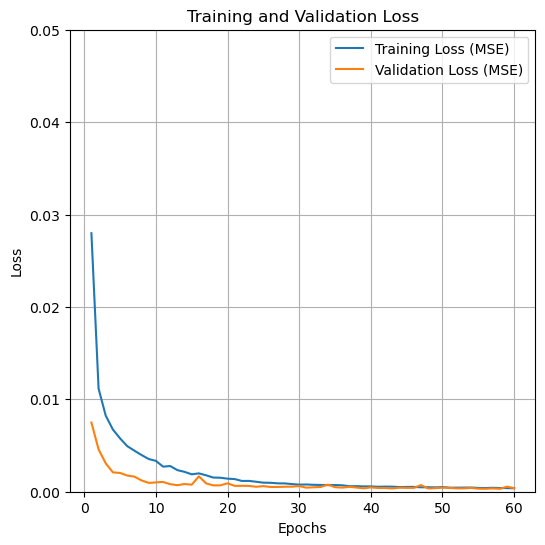

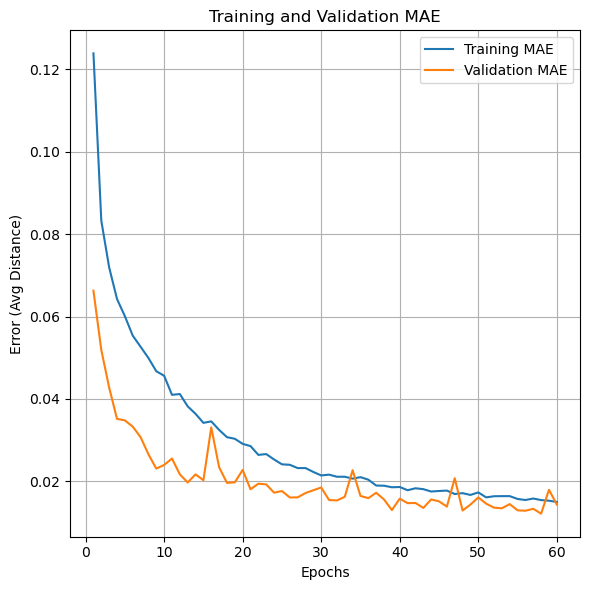

In [13]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(6, 6))

# Plot 1: Loss (MSE)
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss (MSE)')
plt.plot(epochs_range, val_losses, label='Validation Loss (MSE)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.05)
plt.grid()
plt.legend()
plt.savefig('./ReportImages/mobilenet_loss.jpg', bbox_inches='tight', dpi=300)

plt.figure(figsize=(6, 6))
# Plot 2: Mean Absolute Error (MAE)
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_maes, label='Training MAE')
plt.plot(epochs_range, val_maes, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Error (Avg Distance)')
plt.grid()
plt.legend()
plt.savefig('./ReportImages/mobilenet_mae.jpg', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

# Load and test model

In [14]:
#image_path = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\big_corr_1_0013.jpg" # one fixed image

image_path = "./dataset/test_original/frame_000142.png"

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # ImageNet mean and std
    transforms.ConvertImageDtype(torch.float)
])

In [17]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    image = image.unsqueeze(0)
    
    #print(image.shape)
    
    model.eval()  # Disables BatchNorm's training behavior
    
    with torch.no_grad():
        image = image.to(device)  # Fixed: assign back to image
        output = model(image)
    
    return output  # Return just the string label instead of array

In [18]:
model.load_state_dict(torch.load('./models/best_steering_model_xy_MobileNetV3.pth'))
model.eval()
print("Done")

Done


C:\Users\agah2\AppData\Local\Temp\ipykernel_19488\921063827.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_steering_mode

In [19]:
output = predict_image(image_path)
pred_coord = output.cpu().numpy()
print(f"{pred_coord} \n")

coordinates = pred_coord[0]

xpred = coordinates[0]
ypred = coordinates[1]

print(f"x = {xpred}, y = {ypred}")

[[0.3589219 0.5100098]] 

x = 0.3589218854904175, y = 0.5100098252296448


In [20]:
image = Image.open(image_path).convert('RGB')
image_cv = cv2.imread(image_path)

# Denormilize
# Prediction (circle coordinate)
pred_x_norm = xpred
pred_y_norm = ypred
pred_x = int(np.clip(pred_x_norm * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y = int(np.clip(pred_y_norm * image_cv.shape[0], 0, image_cv.shape[0] - 1))

print(f"x = {pred_x}, y = {pred_y}")

x = 80, y = 114


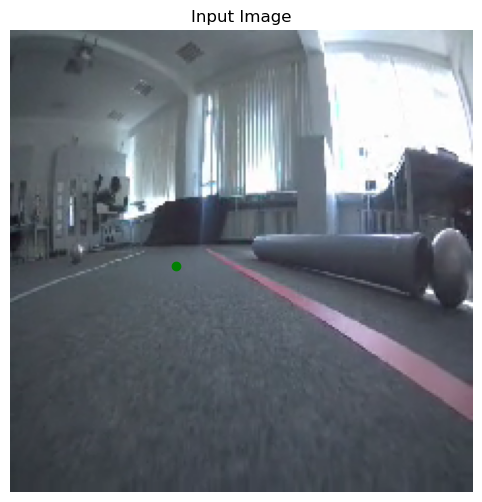

In [21]:
plt.figure(figsize=(12,6))

plt.title("Input Image")
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x, pred_y, 'go')
plt.axis("off")

plt.show()
#plt.savefig("MobileNetV3_all_original_14122025")

# Test with random images

In [22]:
#data_dir = r"C:\Users\agah2\Desktop\JupyterNotebooks\BIP\BIP_images_roboter_cam_allinone\val"

data_dir = "./dataset/test_original"

Random image: frame_006983.png
Done
[[0.4844832  0.67256266]]
x = 0.4844832122325897, y = 0.6725626587867737


C:\Users\agah2\AppData\Local\Temp\ipykernel_19488\963215947.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_steering_mode

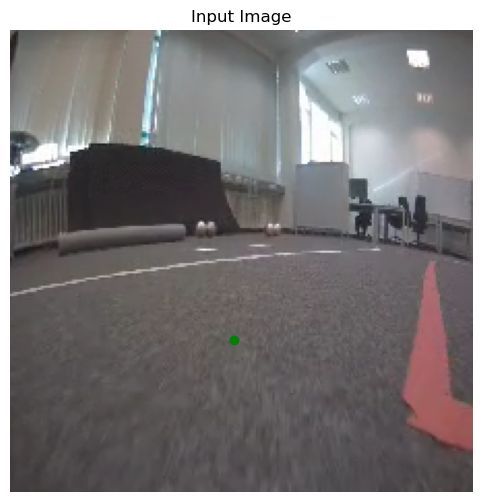

In [23]:
directory = Path(data_dir)
images = [file for file in directory.iterdir()]

random_image = rn.choice(images)
print(f"Random image: {random_image.name}")

image_path = random_image

model.load_state_dict(torch.load('./models/best_steering_model_xy_MobileNetV3.pth'))
model.eval()
print("Done")

output = predict_image(image_path)

pred_coord = output.cpu().numpy()
print(pred_coord)
coordinates = pred_coord[0]

xpred = coordinates[0]
ypred = coordinates[1]
print(f"x = {xpred}, y = {ypred}")

image = Image.open(image_path).convert('RGB')
image_cv = cv2.imread(image_path)


# Prediction (Green Circle)
pred_x_norm = xpred
pred_y_norm = ypred
pred_x = int(np.clip(pred_x_norm * image_cv.shape[1], 0, image_cv.shape[1] - 1))
pred_y = int(np.clip(pred_y_norm * image_cv.shape[0], 0, image_cv.shape[0] - 1))

plt.figure(figsize=(12,6))
plt.title("Input Image")
plt.imshow(image)  # convert from C,H,W → H,W,C
plt.plot(pred_x, pred_y, 'go')
plt.axis("off")
plt.show()

# Measure time of one prediction on GPU

In [24]:
device = torch.device("cuda")
model.to(device).eval()

dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warm-up
for _ in range(10):
    _ = model(dummy_input)

# Setup CUDA events
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

# Measurement
with torch.no_grad():
    starter.record()
    output = model(dummy_input)
    ender.record()
    
    # Wait for the GPU to finish all work
    torch.cuda.synchronize()
    
    curr_time = starter.elapsed_time(ender) # returns time in milliseconds

print(f"GPU Inference time: {curr_time:.2f} ms")

GPU Inference time: 6.43 ms


# Make multiple predictions and measure average

In [25]:
device = torch.device("cuda")
model.to(device).eval()

# Create dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warm-up: 10-20 runs to initialize kernels and memory
print("Warming up")
for _ in range(20):
    _ = model(dummy_input)

# Setup for multiple runs
repetitions = 100
timings = np.zeros((repetitions, 1)) # Array to store results
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

print(f"Starting {repetitions} iterations")

# Measurement Loop
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        
        # WAIT for GPU to finish the work of this specific iteration
        torch.cuda.synchronize()
        
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

# Statistics
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)

print(f"\n Statistics")
print(f"Average Inference Time: {mean_syn:.3f} ms")
print(f"Standard Deviation:     {std_syn:.3f} ms")
print(f"Throughput:             {1000/mean_syn:.2f} FPS")

Warming up
Starting 100 iterations

 Statistics
Average Inference Time: 8.526 ms
Standard Deviation:     1.019 ms
Throughput:             117.28 FPS


# Predict point in Video

In [26]:
# Configuration
model_path = './models/best_steering_model_xy_MobileNetV3.pth'

video_path = './BIP_videos_roboter_cam/u_corr.mp4'

#os.chdir('..')
output_video_path = './inference_videos/output_video_MobileNetV3.mp4' # Where the annotated video will be saved

In [27]:
# Defining Image Preprocessing Transforms
# must match the inference transforms from training/testing
inference_transforms = transforms.Compose([
    # Resize the image to 224x224 (standard input size for ResNet)
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    # Normalize using ImageNet stats (standard for ResNet)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
# Video Processing Loop
def process_video(model, video_path, output_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    # Get video properties for saving the output
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define output video writer
    fourcc = cv2.VideoWriter_fourcc(*'avc1') 
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_count = 0
    print(f"Processing video with {fps} FPS")

    while cap.isOpened():
        ret, frame_cv = cap.read() # Read a frame

        if not ret:
            # End of video stream
            break
        
        frame_count += 1
        
        # Preprocessing (CV2 -> PyTorch Tensor)
        # Convert OpenCV BGR image to PIL RGB image
        frame_rgb = cv2.cvtColor(frame_cv, cv2.COLOR_BGR2RGB)
        frame_pil = Image.fromarray(frame_rgb)

        # Apply transforms
        image_tensor = inference_transforms(frame_pil).unsqueeze(0).to(device) # Add batch dimension (1, 3, H, W)

        # Inference
        with torch.no_grad():
            prediction = model(image_tensor).cpu().numpy()[0]
        
        # Denormalization and Visualization
        # Denormalize coordinates (from 0.0-1.0 to pixel values)
        pred_x_norm, pred_y_norm = prediction
        
        # Clamp coordinates to ensure they are within image bounds
        pred_x = int(np.clip(pred_x_norm * width, 0, width - 1))
        pred_y = int(np.clip(pred_y_norm * height, 0, height - 1))

        # Plot Prediction (Green Circle)
        cv2.circle(frame_cv, (pred_x, pred_y), 8, (0, 255, 0), -1) 
        
        # Draw Steering Vector (Blue Line)
        # From bottom center to the predicted point
        bottom_center = (width // 2, height)
        cv2.line(frame_cv, bottom_center, (pred_x, pred_y), (255, 0, 0), 2)
        
        # Add Info Text
        cv2.putText(frame_cv, f'Target: ({pred_x:.0f}, {pred_y:.0f})', 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Display and Save
        out.write(frame_cv)         # Write the annotated frame to the output video
        cv2.imshow('Video Prediction', frame_cv) # Display the frame
        
        # Wait a small amount of time (1 ms) to allow the window to refresh
        # Press 'q' to quit early
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Cleanup
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Processing finished. Annotated video saved to: {output_path}")

In [29]:
try:
    process_video(model, video_path, output_video_path)
except Exception as e:
    print(f"An error occured: {e}")

Processing video with 21.000021000021 FPS
Processing finished. Annotated video saved to: ./inference_videos/output_video_MobileNetV3.mp4


In [30]:
Video("./inference_videos/output_video_MobileNetV3.mp4")